# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.3 MB/s eta 0:00:00
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41606 sha256=338b25244ad201a6a0c19e774935f8e4cb6ccaafd1a25539b16e0338dcf196db
  Stored in directory: /root/.cache/pip/wheels/c3/26/2b/8ae098b8e9dd7cc1fd0a9131c0f1efea60d710ff7906bf0ab4
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=052536f2c1aacf77fb1e25814c3ad8927032b3192608f748fae8668afa530a3d
  Store

In [3]:
import numpy as np, pandas as pd

!pip install Keras-Preprocessing


import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from tensorflow.keras import metrics
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...


# Importing Data

In [4]:
train=pd.read_csv('/content/drive/MyDrive/train.csv/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test=pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Data Exploration

Checking for missing values

In [6]:
train.shape

(159571, 8)

In [7]:
test.shape

(153164, 2)

In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [10]:
Classification_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[Classification_labels].values

Data Pre-processing

Text Normalization

In [11]:
regex_patterns = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [12]:
def clean_text(text,repeat_text=True, patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if patterns_text:
    for target, patterns in regex_patterns.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

Cleaning Training Data

In [13]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [14]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

Lemmatization

In [15]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [16]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

In [18]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [19]:
lem_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lem_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [20]:
lem_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [21]:
lem_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lem_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

Stopwords Removal

In [22]:
Total_stopword=STOP_WORDS

Adding one and two letter to stop word list

In [23]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [24]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [25]:
for letter in dual_alpha_list:
    Total_stopword.add(letter)
print("Adding to the stop word list is done!!")

Adding to the stop word list is done!!


Checking for the any other words for adding into stopword list

In [26]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in Total_stopword:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip()) 

In [27]:
potential_stopwords = [] 

for line in tqdm_notebook(lem_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [28]:
len(potential_stopwords)

159571

In [29]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [30]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

In [31]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [ ]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

In [ ]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

In [ ]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

In [ ]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [ ]:
print(common_potential_stopwords)

In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

In [ ]:
for word in potential_stopwords:
    Total_stopword.add(word)
print("Done!!")

# Removing Stopwords from Training Data

In [25]:
def stopwords(text, rem_stop_wrds=True):
  output_text = ""
  if rem_stop_wrds:
    text=text.split(" ")
    for word in text:
      if word not in Total_stopword:
        output_text=output_text + " " + word
  else :
    output_text=text

  return str(output_text.strip())      

In [26]:
proc_train_data = [] 

for line in tqdm_notebook(lem_train_data, total=159571): 
    proc_train_data.append(stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [27]:
proc_train_data[152458]

'agree graemel s intention revert nazi wikipedia ha way protect report wp rr revert rule notice board post report revert nazi graemel ha revert nazi unacceptable site s user s admins feel unjustly revert time hour period report revert noticeboard wp rr time'

Removing Stopwords from Test Data

In [28]:
proc_test_data = [] 

for line in tqdm_notebook(lem_test_data, total=153164): 
    proc_test_data.append(stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

Model Building

In [29]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embed_dim_fasttext = 300

Tokenization

In [30]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(proc_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(proc_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(proc_test_data)

In [31]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  149326


Padding

In [32]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [33]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [    2  1424   152     9    28   436     4     7    65   152     9   634
   232   152     9   211    81   119   635   152     9   634     4    29
    35    28     4     7   542   141    27  1162     6     4   452  1147
    28  2507   544    70   152     9    28   232   456   415    25   300
   232   286   189   145    44    46    62   211   112    46     4    15
     8   302  4722    14    28 32694   283    15   232    28 32694   283
   125   210     1   436     4   360   103     3   635    67    79   112
   473  1636    67   210    24   635  1347   112  1727   172    27   172
     5  4861   172     1   130     9    79   621  1333    39   112  1420
   156   172     1  1663   112  1211    18    14    18   562   112   485
    64   210   103     3    67   207  2308   501    64     9   363  1615
   105   211   279   189     6   152     9     9    64    64    35     6
    28   112    64   152     9     6    28   112    64    35   112    64
     9   232   210    81   1

In [34]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [35]:
X_t = X_t[indices]
labels = y[indices]

Splitting data into Training and Validation Set

In [36]:
num_val_samples = int(val_split*X_t.shape[0])
x_tr = X_t[: -num_val_samples]
y_tr = labels[: -num_val_samples]
x_val = X_t[-num_val_samples: ]
y_val = labels[-num_val_samples: ]

In [37]:
print('Number of entries in each category:')
print('training entries: ', y_tr.sum(axis=0))
print('validation entries: ', y_val.sum(axis=0))

Number of entries in each category:
training entries:  [12274  1266  6763   377  6338  1126]
validation entries:  [3020  329 1686  101 1539  279]


Importing Fast tex

In [38]:
embed_index_fasttext = {}
f = open('/content/drive/MyDrive/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embed_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [39]:
embed_matrix_fasttext = np.random.random((len(word_index) + 1, embed_dim_fasttext))
for word, i in word_index.items():
    embed_vector = embed_index_fasttext.get(word)
    if embed_vector is not None:
        embed_matrix_fasttext[i] = embed_vector
print(" Task Completed")

 Task Completed


Creating Model

Talos Grid Search for LSTM Model

In [40]:
def toxic_comment_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(['accuracy',metrics.Precision(name='precision'),metrics.Recall(name='recall'),metrics.F1Score(num_classes=6, name='f1_score')])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [41]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    #'last_activation': ['sigmoid'],
    'last_activation': ['softmax'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [42]:
drscan_results = talos.Scan(x=x_tr,
               y=y_tr,
               x_val=x_val,
               y_val=y_val,
               model=toxic_comment_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 9ms/step - loss: 0.0695 - accuracy: 0.9004 - val_loss: 0.0500 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0503 - accuracy: 0.9817 - val_loss: 0.0470 - val_accuracy: 0.9943


  6%|▌         | 1/18 [01:24<23:55, 84.47s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0702 - accuracy: 0.9416 - val_loss: 0.0493 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0515 - accuracy: 0.9892 - val_loss: 0.0468 - val_accuracy: 0.9943


 11%|█         | 2/18 [02:43<21:40, 81.29s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0619 - accuracy: 0.9528 - val_loss: 0.0481 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0485 - accuracy: 0.9872 - val_loss: 0.0460 - val_accuracy: 0.9943


 17%|█▋        | 3/18 [04:03<20:07, 80.48s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0653 - accuracy: 0.9330 - val_loss: 0.0480 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0498 - accuracy: 0.9840 - val_loss: 0.0464 - val_accuracy: 0.9944


 22%|██▏       | 4/18 [05:22<18:39, 79.94s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0620 - accuracy: 0.9480 - val_loss: 0.0486 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0489 - accuracy: 0.9903 - val_loss: 0.0460 - val_accuracy: 0.9943


 28%|██▊       | 5/18 [06:41<17:17, 79.84s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0649 - accuracy: 0.9334 - val_loss: 0.0501 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0509 - accuracy: 0.9928 - val_loss: 0.0467 - val_accuracy: 0.9944


 33%|███▎      | 6/18 [08:01<15:55, 79.63s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0641 - accuracy: 0.9249 - val_loss: 0.0485 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0491 - accuracy: 0.9889 - val_loss: 0.0465 - val_accuracy: 0.9942


 39%|███▉      | 7/18 [09:23<14:45, 80.54s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0680 - accuracy: 0.9117 - val_loss: 0.0493 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0509 - accuracy: 0.9900 - val_loss: 0.0465 - val_accuracy: 0.9942


 44%|████▍     | 8/18 [10:46<13:32, 81.29s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0617 - accuracy: 0.9648 - val_loss: 0.0483 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0492 - accuracy: 0.9881 - val_loss: 0.0464 - val_accuracy: 0.9944


 50%|█████     | 9/18 [12:09<12:16, 81.78s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0638 - accuracy: 0.9119 - val_loss: 0.0484 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0503 - accuracy: 0.9922 - val_loss: 0.0462 - val_accuracy: 0.9944


 56%|█████▌    | 10/18 [13:32<10:58, 82.33s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0622 - accuracy: 0.9288 - val_loss: 0.0486 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0488 - accuracy: 0.9866 - val_loss: 0.0464 - val_accuracy: 0.9943


 61%|██████    | 11/18 [14:58<09:43, 83.29s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0640 - accuracy: 0.9183 - val_loss: 0.0498 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0506 - accuracy: 0.9816 - val_loss: 0.0474 - val_accuracy: 0.9934


 67%|██████▋   | 12/18 [16:21<08:20, 83.35s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0638 - accuracy: 0.9265 - val_loss: 0.0481 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0491 - accuracy: 0.9925 - val_loss: 0.0461 - val_accuracy: 0.9944


 72%|███████▏  | 13/18 [17:46<06:58, 83.63s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0657 - accuracy: 0.9328 - val_loss: 0.0499 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0505 - accuracy: 0.9875 - val_loss: 0.0475 - val_accuracy: 0.9944


 78%|███████▊  | 14/18 [19:10<05:35, 83.95s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0608 - accuracy: 0.9387 - val_loss: 0.0471 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0481 - accuracy: 0.9826 - val_loss: 0.0453 - val_accuracy: 0.9942


 83%|████████▎ | 15/18 [20:34<04:11, 83.90s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0648 - accuracy: 0.9077 - val_loss: 0.0494 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0509 - accuracy: 0.9906 - val_loss: 0.0462 - val_accuracy: 0.9944


 89%|████████▉ | 16/18 [21:58<02:48, 84.06s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0617 - accuracy: 0.9431 - val_loss: 0.0480 - val_accuracy: 0.9931
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.0456 - val_accuracy: 0.9943


 94%|█████████▍| 17/18 [23:23<01:24, 84.23s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0649 - accuracy: 0.9178 - val_loss: 0.0501 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0506 - accuracy: 0.9831 - val_loss: 0.0463 - val_accuracy: 0.9942


100%|██████████| 18/18 [24:47<00:00, 82.62s/it]


In [43]:
model_id = drscan_results.data['val_accuracy'].astype('float').argmax()
model_id

3

In [44]:
analyze_object = talos.Analyze(drscan_results)

In [45]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[0.2, 50, 2, 32, 'relu', '04/23/23-150607', 2, 40, 'adam',
        82.63015222549438, '04/23/23-150729', 'softmax', 0],
       [0.1, 60, 2, 32, 'relu', '04/23/23-151019', 2, 30, 'adam',
        83.38044691085815, '04/23/23-151142', 'softmax', 1],
       [0.2, 40, 2, 32, 'relu', '04/23/23-145800', 2, 40, 'adam',
        78.23966979980469, '04/23/23-145919', 'softmax', 2],
       [0.2, 40, 2, 32, 'relu', '04/23/23-150039', 2, 50, 'adam',
        78.35046696662903, '04/23/23-150157', 'softmax', 3],
       [0.2, 60, 2, 32, 'relu', '04/23/23-151432', 2, 40, 'adam',
        83.52988386154175, '04/23/23-151555', 'softmax', 4],
       [0.2, 60, 2, 32, 'relu', '04/23/23-151143', 2, 30, 'adam',
        83.79713296890259, '04/23/23-151307', 'softmax', 5],
       [0.1, 50, 2, 32, 'relu', '04/23/23-150444', 2, 40, 'adam',
        81.96586585044861, '04/23/23-150606', 'softmax', 6],
       [0.1, 40, 2, 32, 'relu', '04/23/23-145919', 2, 50, 'adam',
        78.76945877075195, '04/23/23-150038',

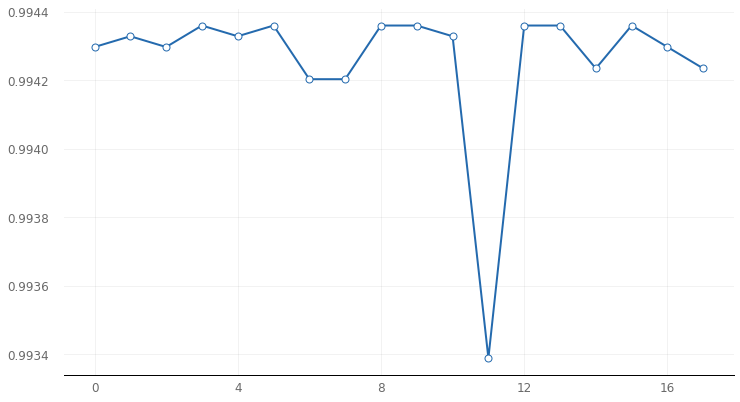

In [46]:
analyze_object.plot_line('val_accuracy')

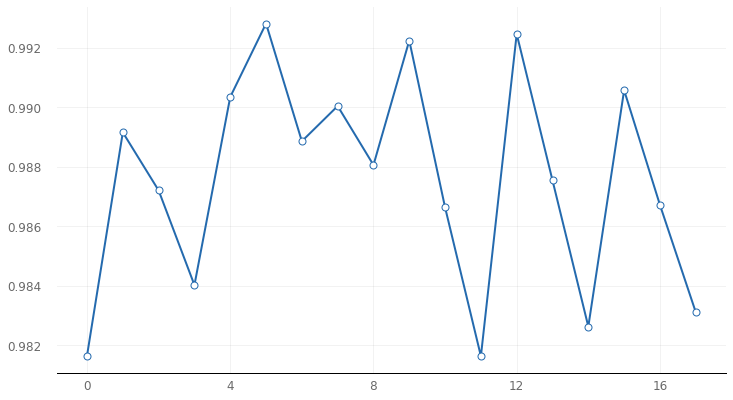

In [47]:
analyze_object.plot_line('accuracy')

Talos Grid Search for LSTM-CNN Model

In [48]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)
  
  x = GlobalMaxPool1D()(x)
  
  x = BatchNormalization()(x)
  
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], 
              optimizer=params['optimizer'], 
              metrics=['accuracy',metrics.Precision(name='precision'),metrics.Recall(name='recall'),metrics.F1Score(num_classes=6, name='f1_score')])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [49]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    #'last_activation': ['sigmoid'],
    'last_activation': ['softmax'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [50]:
scan_results = talos.Scan(x=x_tr,
               y=y_tr,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 55s 11ms/step - loss: 0.0639 - accuracy: 0.9239 - val_loss: 0.0520 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0523 - accuracy: 0.9922 - val_loss: 0.0539 - val_accuracy: 0.9941


  6%|▋         | 1/16 [01:42<25:38, 102.59s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0757 - accuracy: 0.9043 - val_loss: 0.0534 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0548 - accuracy: 0.9814 - val_loss: 0.0488 - val_accuracy: 0.9944


 12%|█▎        | 2/16 [04:08<29:54, 128.20s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0672 - accuracy: 0.9191 - val_loss: 0.0512 - val_accuracy: 0.9908
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0522 - accuracy: 0.9758 - val_loss: 0.0525 - val_accuracy: 0.9899


 19%|█▉        | 3/16 [06:34<29:33, 136.44s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0688 - accuracy: 0.8953 - val_loss: 0.0500 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0535 - accuracy: 0.9765 - val_loss: 0.0478 - val_accuracy: 0.9941


 25%|██▌       | 4/16 [09:01<28:03, 140.27s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0686 - accuracy: 0.8777 - val_loss: 0.0501 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0521 - accuracy: 0.9832 - val_loss: 0.0491 - val_accuracy: 0.9944


 31%|███▏      | 5/16 [11:27<26:06, 142.39s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0757 - accuracy: 0.9016 - val_loss: 0.0540 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0544 - accuracy: 0.9830 - val_loss: 0.0504 - val_accuracy: 0.9944


 38%|███▊      | 6/16 [13:05<21:15, 127.53s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0659 - accuracy: 0.8906 - val_loss: 0.0500 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0517 - accuracy: 0.9696 - val_loss: 0.0489 - val_accuracy: 0.9940


 44%|████▍     | 7/16 [14:44<17:43, 118.16s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0710 - accuracy: 0.8980 - val_loss: 0.0675 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0540 - accuracy: 0.9877 - val_loss: 0.0494 - val_accuracy: 0.9941


 50%|█████     | 8/16 [17:11<16:57, 127.16s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 52s 12ms/step - loss: 0.0679 - accuracy: 0.8873 - val_loss: 0.0501 - val_accuracy: 0.9928
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0520 - accuracy: 0.9810 - val_loss: 0.0511 - val_accuracy: 0.9943


 56%|█████▋    | 9/16 [18:51<13:51, 118.84s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0721 - accuracy: 0.9118 - val_loss: 0.0511 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0546 - accuracy: 0.9860 - val_loss: 0.0520 - val_accuracy: 0.9944


 62%|██████▎   | 10/16 [20:30<11:16, 112.71s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0652 - accuracy: 0.8954 - val_loss: 0.0544 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0526 - accuracy: 0.9787 - val_loss: 0.0486 - val_accuracy: 0.9914


 69%|██████▉   | 11/16 [22:09<09:02, 108.51s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0690 - accuracy: 0.8871 - val_loss: 0.0528 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0539 - accuracy: 0.9752 - val_loss: 0.0487 - val_accuracy: 0.9943


 75%|███████▌  | 12/16 [23:48<07:02, 105.67s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0683 - accuracy: 0.8795 - val_loss: 0.0571 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0523 - accuracy: 0.9674 - val_loss: 0.0475 - val_accuracy: 0.9888


 81%|████████▏ | 13/16 [25:27<05:10, 103.57s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0712 - accuracy: 0.9340 - val_loss: 0.0524 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0542 - accuracy: 0.9907 - val_loss: 0.0486 - val_accuracy: 0.9944


 88%|████████▊ | 14/16 [27:06<03:24, 102.28s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0633 - accuracy: 0.9020 - val_loss: 0.0539 - val_accuracy: 0.9891
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.0479 - val_accuracy: 0.9936


 94%|█████████▍| 15/16 [28:46<01:41, 101.41s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'softmax', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0663 - accuracy: 0.9153 - val_loss: 0.0517 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0540 - accuracy: 0.9801 - val_loss: 0.0519 - val_accuracy: 0.9943


100%|██████████| 16/16 [31:12<00:00, 117.04s/it]


In [51]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [52]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,output_count_lstm,output_1_count_dense,...,filters,kernel_size,batch_size,pool_size,epochs,optimizer,activation,last_activation,dropout,loss
8,04/23/23-153557,04/23/23-153736,99.498246,2,0.052032,0.981035,0.051086,0.994297,60,40,...,64,3,32,3,2,adam,relu,softmax,0.1,binary_crossentropy


In [53]:
analyze_object = talos.Analyze(scan_results)

In [54]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[0.2, 50, 2, 64, 30, 32, 'relu', '04/23/23-152028', 2, 3, 40, 3,
        'adam', 145.17101407051086, '04/23/23-152253', 'softmax', 0],
       [0.1, 50, 2, 64, 30, 32, 'relu', '04/23/23-152747', 2, 3, 50, 3,
        'adam', 145.19786548614502, '04/23/23-153012', 'softmax', 1],
       [0.2, 50, 2, 64, 30, 32, 'relu', '04/23/23-153013', 2, 3, 50, 3,
        'adam', 97.68642330169678, '04/23/23-153150', 'softmax', 2],
       [0.2, 60, 2, 64, 30, 32, 'relu', '04/23/23-153737', 2, 3, 40, 3,
        'adam', 97.91400027275085, '04/23/23-153915', 'softmax', 3],
       [0.2, 60, 2, 64, 30, 32, 'relu', '04/23/23-154413', 2, 3, 50, 3,
        'adam', 98.24295210838318, '04/23/23-154551', 'softmax', 4],
       [0.2, 60, 2, 64, 40, 32, 'relu', '04/23/23-154732', 2, 3, 50, 3,
        'adam', 145.25234484672546, '04/23/23-154957', 'softmax', 5],
       [0.1, 60, 2, 64, 30, 32, 'relu', '04/23/23-153557', 2, 3, 40, 3,
        'adam', 99.49824571609497, '04/23/23-153736', 'softmax', 6],
       [0.

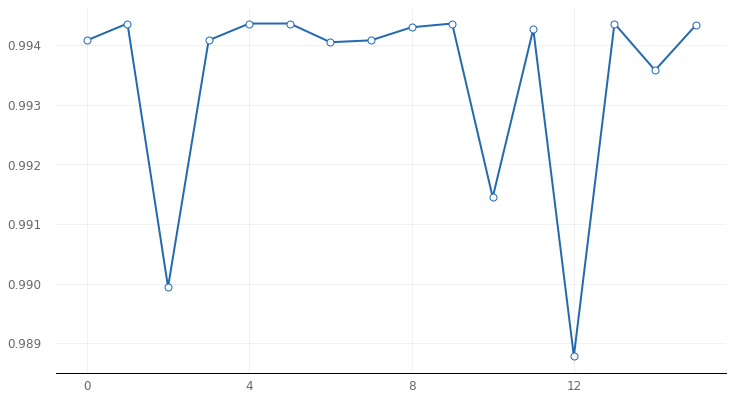

In [55]:
analyze_object.plot_line('val_accuracy')

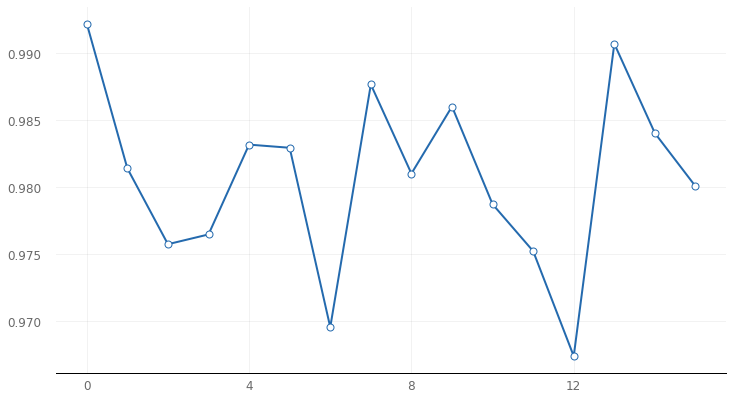

In [56]:
analyze_object.plot_line('accuracy')

Training Model with Best Parameters

LSTM

In [57]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [58]:
embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [59]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="softmax", kernel_initializer='glorot_uniform')(x)

In [60]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',metrics.Precision(name='precision'),
                         metrics.Recall(name='recall'),
                         metrics.F1Score(num_classes=6, name='f1_score')])

In [61]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44798100  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [62]:
model_info_1=model_1.fit(x_tr,y_tr, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0643 - accuracy: 0.9343 - val_loss: 0.0501 - val_accuracy: 0.9943
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0497 - accuracy: 0.9843 - val_loss: 0.0480 - val_accuracy: 0.9944


LSTM-CNN

In [63]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [64]:
embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [65]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="softmax", kernel_initializer='glorot_uniform')(x)

In [66]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',metrics.Precision(name='precision'),
                         metrics.Recall(name='recall'),
                         metrics.F1Score(num_classes=6, name='f1_score')])

In [67]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44798100  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

fit the model on training data

In [68]:
model_info_2=model_2.fit(x_tr,y_tr, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0677 - accuracy: 0.9212 - val_loss: 0.0567 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0546 - accuracy: 0.9861 - val_loss: 0.0495 - val_accuracy: 0.9944


Plotting Graphs

LSTM

Loss graph

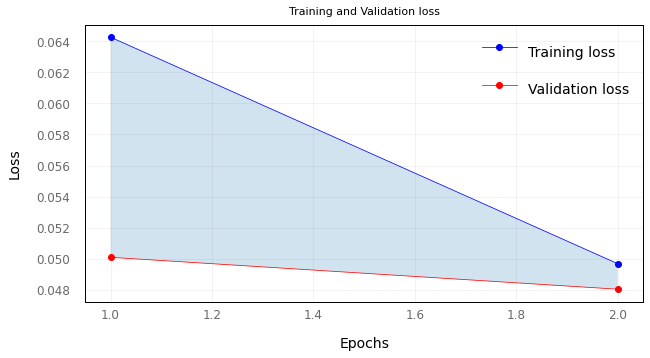

In [81]:
import matplotlib.pyplot as plt

loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 5))
plt.fill_between(epochs, loss, val_loss, alpha=0.2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

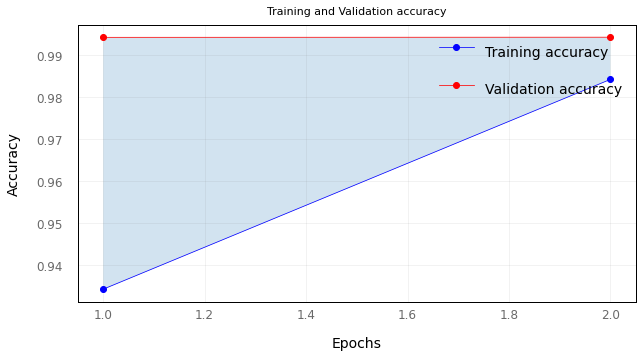

In [79]:
import matplotlib.pyplot as plt

loss = model_info_1.history['accuracy']
val_loss = model_info_1.history['val_accuracy']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 5))
plt.fill_between(epochs, accuracy, val_accuracy, alpha=0.2)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

LSTM-CNN

Loss graph

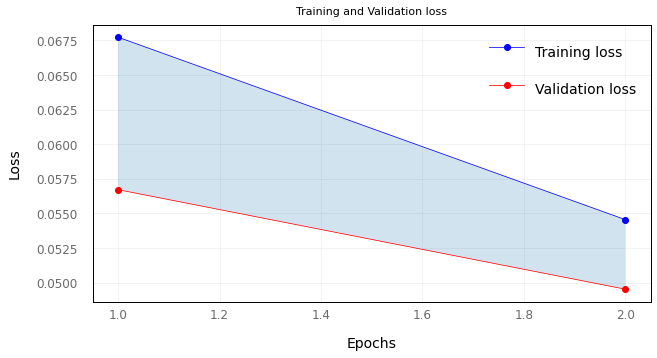

In [77]:
import matplotlib.pyplot as plt

loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 5))
plt.fill_between(epochs, loss, val_loss, alpha=0.2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

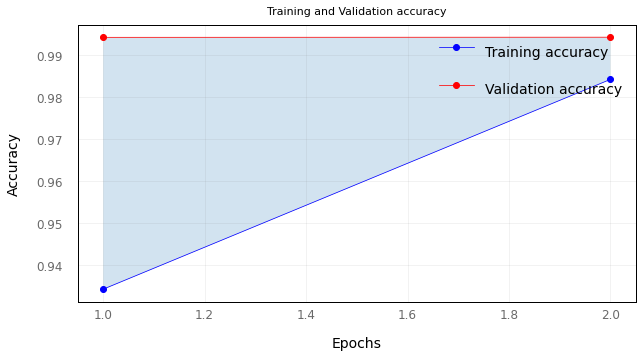

In [78]:
import matplotlib.pyplot as plt

loss = model_info_2.history['accuracy']
val_loss = model_info_2.history['val_accuracy']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 5))
plt.fill_between(epochs, accuracy, val_accuracy, alpha=0.2)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Saving the model

In [82]:
model_1.save(filepath="/content/model1.h5")

In [83]:
model_2.save(filepath="/content/model2.h5")

Loading saved model

In [84]:
loaded_model_1 = keras.models.load_model(filepath="/content/model1.h5")

In [85]:
loaded_model_2 = keras.models.load_model(filepath="/content/model2.h5")

Generating the output

LSTM

In [86]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 523s 3ms/step


In [88]:
sample_submission = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/Submission_LSTM.csv', index=False)

LSTM-CNN

In [89]:
test_values_2 = loaded_model_2.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 576s 4ms/step


In [91]:
sample_submission = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')
test_values_2=pd.DataFrame(test_values_2,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_2],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/Submission_CNN.csv', index=False)

Testing the created model

In [92]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = model_1.predict(new_string)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [93]:
def toxicity_level_2(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = model_2.predict(new_string)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [98]:
toxicity_level('fuck ofF!!')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         86%
Severe Toxic:  0%
Obscene:       13%
Threat:        0%
Insult:        1%
Identity Hate: 0%



In [99]:
toxicity_level_2('fuck ofF!!')

1/1 [==============================] - 0s 31ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         90%
Severe Toxic:  0%
Obscene:       9%
Threat:        0%
Insult:        1%
Identity Hate: 0%



In [100]:
toxicity_level_2('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         87%
Severe Toxic:  0%
Obscene:       11%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [101]:
toxicity_level('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 29ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         80%
Severe Toxic:  0%
Obscene:       18%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [104]:
toxicity_level('such an idiot')

1/1 [==============================] - 0s 32ms/step
Toxicity levels for 'such an idiot':
Toxic:         79%
Severe Toxic:  0%
Obscene:       8%
Threat:        0%
Insult:        13%
Identity Hate: 0%



In [105]:
toxicity_level_2('such an idiot')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'such an idiot':
Toxic:         83%
Severe Toxic:  0%
Obscene:       11%
Threat:        0%
Insult:        6%
Identity Hate: 0%



In [112]:
toxicity_level('worst fucking product ever seen')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'worst fucking product ever seen':
Toxic:         79%
Severe Toxic:  0%
Obscene:       6%
Threat:        1%
Insult:        14%
Identity Hate: 0%



In [113]:
toxicity_level_2('worst fucking product ever seen')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'worst fucking product ever seen':
Toxic:         84%
Severe Toxic:  0%
Obscene:       6%
Threat:        1%
Insult:        9%
Identity Hate: 0%



In [119]:
toxicity_level_2('you bloody moron')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'you bloody moron':
Toxic:         85%
Severe Toxic:  0%
Obscene:       10%
Threat:        0%
Insult:        5%
Identity Hate: 0%



In [120]:
toxicity_level('you bloody moron')

1/1 [==============================] - 0s 31ms/step
Toxicity levels for 'you bloody moron':
Toxic:         84%
Severe Toxic:  0%
Obscene:       8%
Threat:        0%
Insult:        8%
Identity Hate: 0%



In [131]:
toxicity_level('ugly and fat dumbass')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'ugly and fat dumbass':
Toxic:         77%
Severe Toxic:  1%
Obscene:       8%
Threat:        0%
Insult:        13%
Identity Hate: 1%



In [132]:
toxicity_level_2('ugly and fat dumbass')

1/1 [==============================] - 0s 29ms/step
Toxicity levels for 'ugly and fat dumbass':
Toxic:         64%
Severe Toxic:  2%
Obscene:       17%
Threat:        1%
Insult:        14%
Identity Hate: 2%



In [134]:
toxicity_level('fatass bitch')

1/1 [==============================] - 0s 29ms/step
Toxicity levels for 'fatass bitch':
Toxic:         88%
Severe Toxic:  0%
Obscene:       10%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [135]:
toxicity_level_2('fatass bitch')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'fatass bitch':
Toxic:         88%
Severe Toxic:  0%
Obscene:       10%
Threat:        0%
Insult:        2%
Identity Hate: 0%



In [142]:
toxicity_level('you are so ugly and stupid')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'you are so ugly and stupid':
Toxic:         76%
Severe Toxic:  0%
Obscene:       9%
Threat:        0%
Insult:        15%
Identity Hate: 0%



In [141]:
toxicity_level_2('you are so ugly and stupid')

1/1 [==============================] - 0s 29ms/step
Toxicity levels for 'you are so ugly and stupid':
Toxic:         79%
Severe Toxic:  0%
Obscene:       12%
Threat:        0%
Insult:        9%
Identity Hate: 0%

